<a href="https://colab.research.google.com/github/climatechange-ai-tutorials/citylearn/blob/main/citylearn_ccai_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIT License
#
#@title Copyright (c) 2024 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [1]:
!python --version

Python 3.10.12


In [2]:
%%capture

# the environment we will be working with and its dependencies
!pip install gymnasium
!pip install nrel-pysam
!pip install simplejson
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0

# to generate static figures
!pip install matplotlib
!pip install seaborn

# provide standard RL algorithms
!pip install --no-deps stable-baselines3

# results submission
!pip install requests
!pip install beautifulsoup4

# progress bar
!pip install tqdm

!pip install gymnasium==0.29
!pip install shimmy==1.3.0

In [3]:
# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper
)

# RL algorithms
from stable_baselines3 import SAC

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [4]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

# ignore deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'

In [6]:
display('All CityLearn datasets:', sorted(DataSet.get_names()))

'All CityLearn datasets:'

['baeda_3dem',
 'ca_alameda_county_neighborhood',
 'citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all',
 'citylearn_challenge_2023_phase_1',
 'citylearn_challenge_2023_phase_2_local_evaluation',
 'citylearn_challenge_2023_phase_2_online_evaluation_1',
 'citylearn_challenge_2023_phase_2_online_evaluation_2',
 'citylearn_challenge_2023_phase_2_online_evaluation_3',
 'citylearn_challenge_2023_phase_3_1',
 'citylearn_challenge_2023_phase_3_2',
 'citylearn_challenge_2023_phase_3_3',
 'tx_travis_county_neighborhood',
 'vt_chittenden_county_neighborhood']

In [7]:
schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

In [8]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

month  hour  day_type  daylight_savings_status  \
0      7    24         7                        0   
1      8     1         1                        0   
2      8     2         1                        0   
3      8     3         1                        0   
4      8     4         1                        0   

   indoor_dry_bulb_temperature  average_unmet_cooling_setpoint_difference  \
0                          NaN                                        NaN   
1                          NaN                                        NaN   
2                          NaN                                        NaN   
3                          NaN                                        NaN   
4                          NaN                                        NaN   

   indoor_relative_humidity  non_shiftable_load  dhw_demand  cooling_demand  \
0                       NaN            2.275800         0.0             0.0   
1                       NaN            0.851167         0.0             0.0   
2                       NaN            0.834600         0.0             0.0   
3                       NaN            0.838167         0.0             0.0   
4                       NaN            1.478433         0.0             0.0   

   heating_demand  solar_generation  
0             0.0               0.0  
1             0.0               0.0  
2             0.0               0.0  
3             0.0               0.0  
4             0.0               0.0

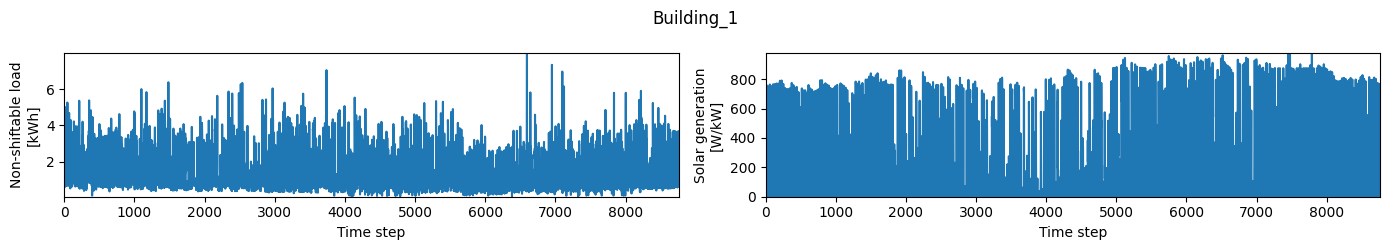

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2.5))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar generation\n[W/kW]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

## Data Preprocessing

1. 4 buildings randomly selected.
2. Limit to 7-day period.

In [10]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """Randomly select buildings from CityLearn dataset.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    buildings_to_exclude: list[str]
        List of buildings to exclude from selection pool.

    Returns
    -------
    buildings: list[str]
        List of selected building names.
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    return buildings

In [11]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    return simulation_start_time_step, simulation_end_time_step

In [12]:
RANDOM_SEED = 5340
print('Random seed:', RANDOM_SEED)

Random seed: 5340


In [13]:
BUILDING_COUNT = 4
BUILDINGS = select_buildings(
    DATASET_NAME,
    BUILDING_COUNT,
    RANDOM_SEED,
    ["Building_4"] # to exclude
)
print('Selected building:', BUILDINGS)

Selected building: ['Building_6', 'Building_8', 'Building_14', 'Building_16']


In [14]:
DAY_COUNT = 7
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP = select_simulation_period(
    DATASET_NAME,
    DAY_COUNT,
    RANDOM_SEED
)

print(
    f'Selected {DAY_COUNT}-day simulation period:',
    (SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
)

Selected 7-day simulation period: (6216, 6383)


In [15]:
ACTIVE_OBSERVATIONS = ['hour']

In [16]:
CENTRAL_AGENT = True

# Initialize a CityLearn Environment
***

In [17]:
env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [18]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 168
environment uses central agent: True
Number of buildings: 4


In [19]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc[b.time_step] for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption[b.time_step]
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.capacity_loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})
print()
# active observations
print('Active observations:', {b.name: b.active_observations for b in env.buildings})
# active actions
print('Active actions:', {b.name: b.active_actions for b in env.buildings})

Electrical storage capacity: {'Building_6': 6.4, 'Building_8': 6.4, 'Building_14': 6.4, 'Building_16': 6.4}
Electrical storage nominal power: {'Building_6': 5.0, 'Building_8': 5.0, 'Building_14': 5.0, 'Building_16': 5.0}
Electrical storage loss_coefficient: {'Building_6': 0.0, 'Building_8': 0.0, 'Building_14': 0.0, 'Building_16': 0.0}
Electrical storage soc: {'Building_6': 0.0, 'Building_8': 0.0, 'Building_14': 0.0, 'Building_16': 0.0}
Electrical storage efficiency: {'Building_6': 0.9, 'Building_8': 0.9, 'Building_14': 0.9, 'Building_16': 0.9}
Electrical storage electricity consumption: {'Building_6': 0.0, 'Building_8': 0.0, 'Building_14': 0.0, 'Building_16': 0.0}
Electrical storage capacity loss coefficient: {'Building_6': 1e-05, 'Building_8': 1e-05, 'Building_14': 1e-05, 'Building_16': 1e-05}

PV nominal power: {'Building_6': 4.0, 'Building_8': 4.0, 'Building_14': 5.0, 'Building_16': 5.0}

Active observations: {'Building_6': ['hour'], 'Building_8': ['hour'], 'Building_14': ['hour'], 

# Key Performance Indicators for Evaluation
---

We evaluate the control agents' performance using five key performance indicators (KPIs) that are to be minimized: 
1. electricity cost,
2. carbon emissions,
3. average daily peak,
4. (1 - load factor), and
5. ramping.

Average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. 
Electricity cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

1. 
Electricity cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$, where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

2. 
Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

3. 
Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

4. 
Load factor is defined as the average ratio of monthly average and peak $E_{h}^{\textrm{district}}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. Load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E_{d \cdot m + h}^{\textrm{district}}
            \right ) \div d
        }{
            \textrm{max} \left (E_{d \cdot m}^{\textrm{district}}, \dots, E_{d \cdot m + d - 1}^{\textrm{district}} \right )
    }\Big) \div n
$$

5. 
Ramping is defined as the absolute difference of consecutive $E_h^{\textrm{district}}$. It represents the smoothness of the district's load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{h=0}^{n-1}  \lvert E_{h}^{\textrm{district}} - E_{h - 1}^{\textrm{district}} \rvert
$$


KPIs are normalised with respect to the baseline when buildings are not equipped with batteries. KPI < 1.0 is preferred.
$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

In [20]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.unwrapped.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [21]:
def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 2
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = 2 # min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.5*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig

In [22]:
def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.5*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [23]:
def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 2 # 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 2*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [24]:
def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 2)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

In [25]:
def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 2 # 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 2*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [26]:
def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    print('Building-level simulation period load profiles:')
    _ = plot_building_load_profiles(envs)
    plt.show()

    print('Building-level daily-average load profiles:')
    _ = plot_building_load_profiles(envs, daily_average=True)
    plt.show()

    print('Battery SoC profiles:')
    _ = plot_battery_soc_profiles(envs)
    plt.show()

    print('#'*8 + ' DISTRICT-LEVEL ' + '#'*8)
    print('District-level KPIs:')
    _ = plot_district_kpis(envs)
    plt.show()

    print('District-level simulation period load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

    print('District-level daily-average load profiles:')
    _ = plot_district_load_profiles(envs, daily_average=True)
    plt.show()

<a name="experiment-1"></a>

# Experiment 1: Baseline
---

In [27]:
baseline_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [28]:
baseline_model = BaselineAgent(baseline_env)

In [29]:
# always start by reseting the environment
observations, _ = baseline_env.reset()

# step through the environment until terminal
# state is reached i.e., the control episode ends
while not baseline_env.terminated:
    # select actions from the model
    actions = baseline_model.predict(observations)

    # apply selected actions to the environment
    observations, _, _, _, _ = baseline_env.step(actions)

######## BUILDING-LEVEL ########
Building-level KPIs:


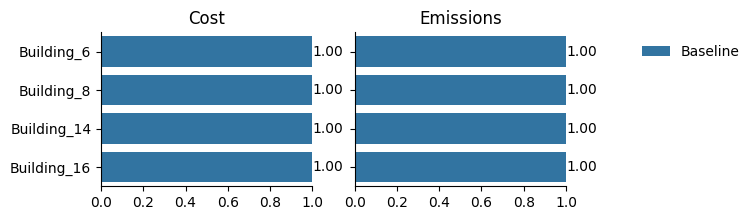

Building-level simulation period load profiles:


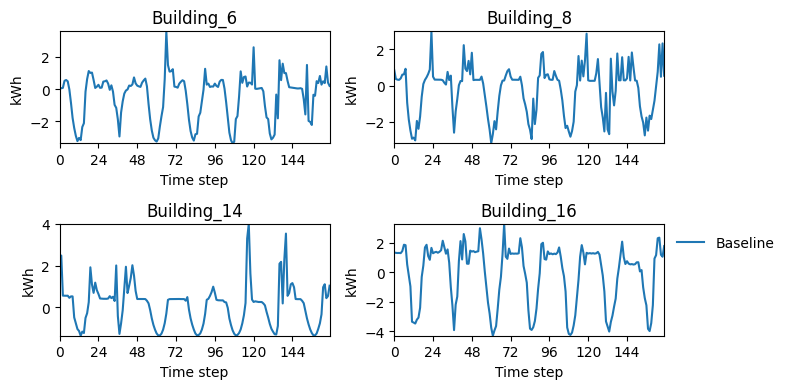

Building-level daily-average load profiles:


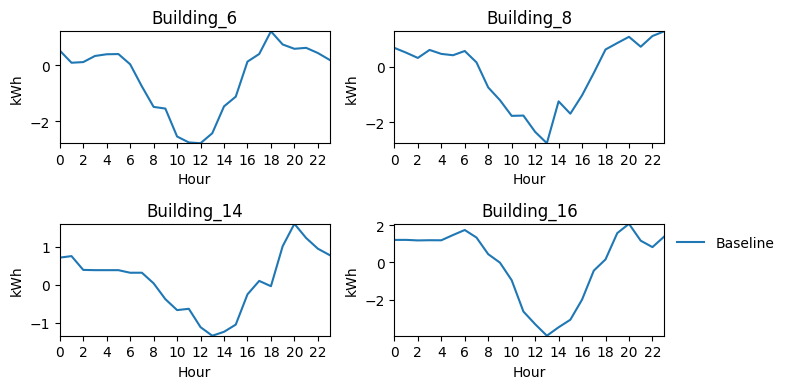

Battery SoC profiles:


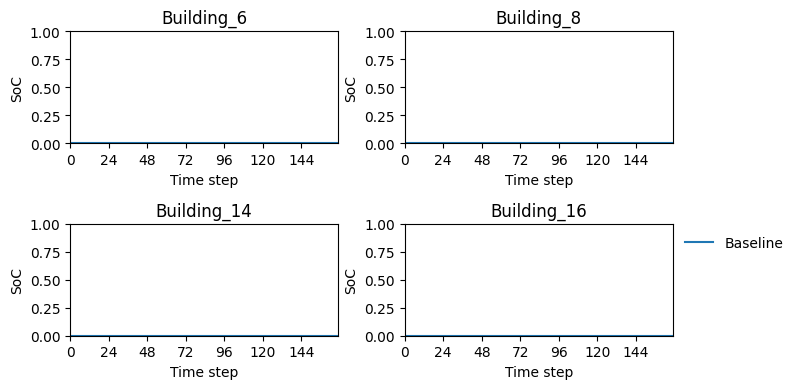

######## DISTRICT-LEVEL ########
District-level KPIs:


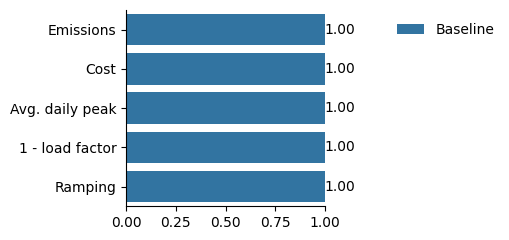

District-level simulation period load profiles:


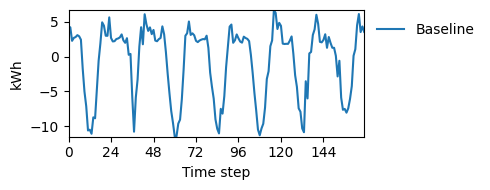

District-level daily-average load profiles:


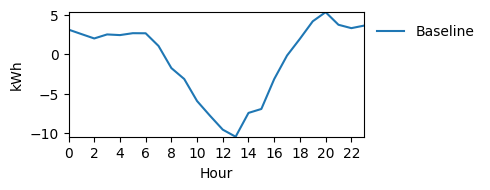

In [30]:
plot_simulation_summary({
    'Baseline': baseline_env,
})

<a name="experiment-2"></a>
# Experiment 2: Tabular Q-Learning (TQL)

---

Experiment 2A: TQL1
---

$\alpha = 0.005$

In [31]:
tql_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [32]:
# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 7} # changed from 12!!

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

In [33]:
tql_env = TabularQLearningWrapper(
    tql_env,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

In [34]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i = 3
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.unwrapped.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', tql_episodes)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model = TabularQLearning(
    env=tql_env,
    random_seed=RANDOM_SEED,
    **tql_kwargs
)

for i in tqdm(range(tql_episodes)):
    _ = tql_model.learn()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(


Q-Table dimension: (24, 2401)
Number of episodes to train: 1035


100%|██████████| 1035/1035 [26:50<00:00,  1.56s/it]


######## BUILDING-LEVEL ########
Building-level KPIs:


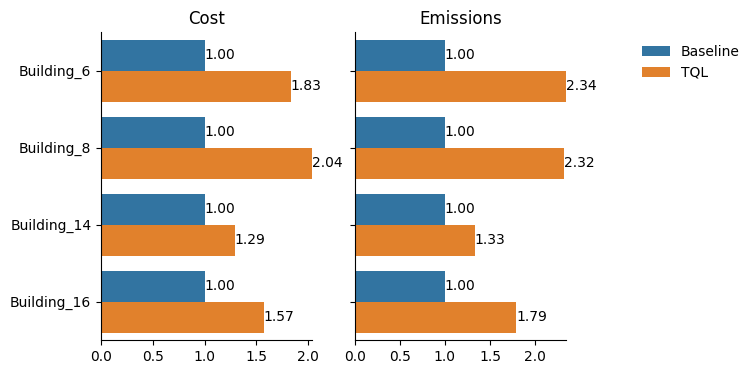

Building-level simulation period load profiles:


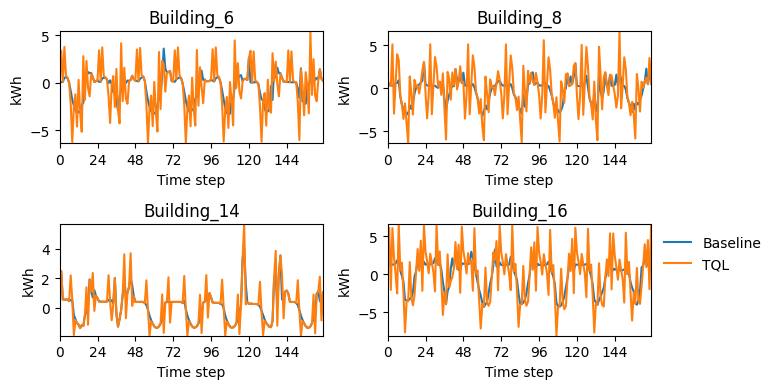

Building-level daily-average load profiles:


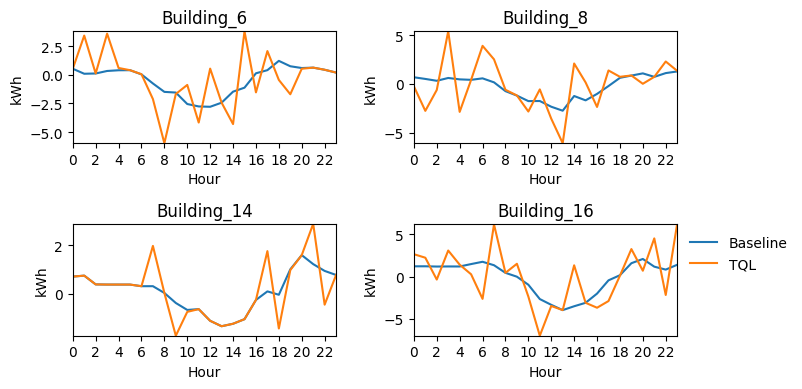

Battery SoC profiles:


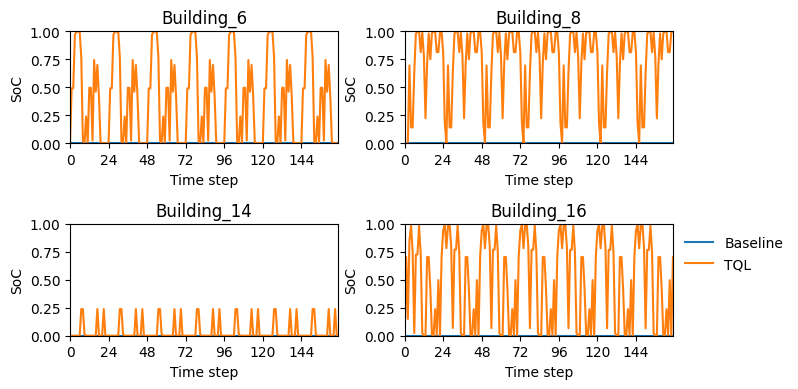

######## DISTRICT-LEVEL ########
District-level KPIs:


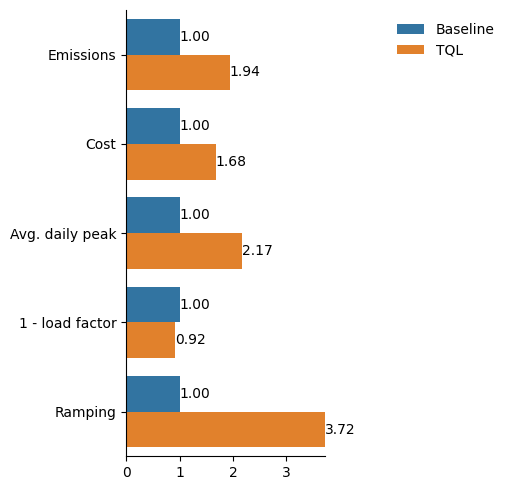

District-level simulation period load profiles:


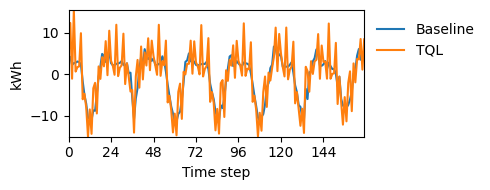

District-level daily-average load profiles:


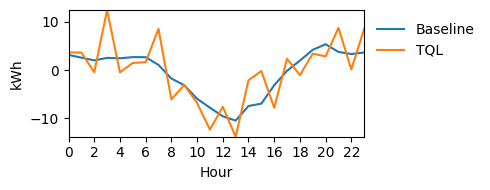

In [35]:
observations, _ = tql_env.reset()

while not tql_env.unwrapped.terminated:
    actions = tql_model.predict(observations, deterministic=True)
    observations, _, _, _, _ = tql_env.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    'TQL': tql_env
})

Experiment 2B: TQL2
---

$\alpha = 0.01$

In [39]:
## TQL V2 ##
tql_env2 = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 7} # changed from 12!!

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env2.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

tql_env2 = TabularQLearningWrapper(
    tql_env2,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)


# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i2 = 3
m2 = tql_env2.observation_space[0].n
n2 = tql_env2.action_space[0].n
t2 = tql_env2.unwrapped.time_steps - 1
tql_episodes2 = m2*n2*i2/t2
tql_episodes2 = int(tql_episodes2)
print('Q-Table dimension:', (m2, n2))
print('Number of episodes to train:', tql_episodes2)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs2 = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.01, # CHANGED FROM 0.005
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model2 = TabularQLearning(
    env=tql_env2,
    random_seed=RANDOM_SEED,
    **tql_kwargs2
)

for i in tqdm(range(tql_episodes2)):
    _ = tql_model2.learn()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(


Q-Table dimension: (24, 2401)
Number of episodes to train: 1035


100%|██████████| 1035/1035 [27:05<00:00,  1.57s/it]


######## BUILDING-LEVEL ########
Building-level KPIs:


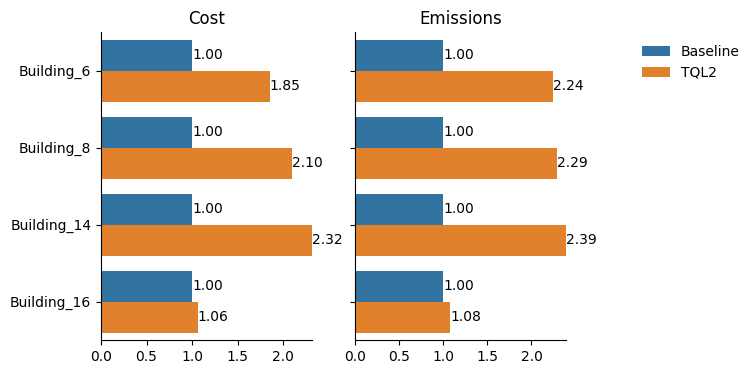

Building-level simulation period load profiles:


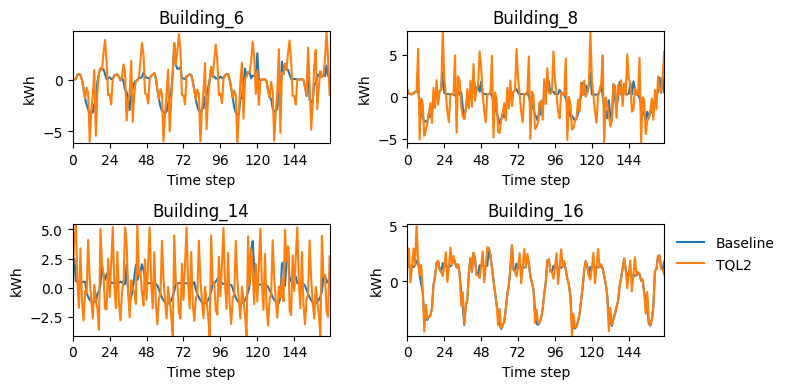

Building-level daily-average load profiles:


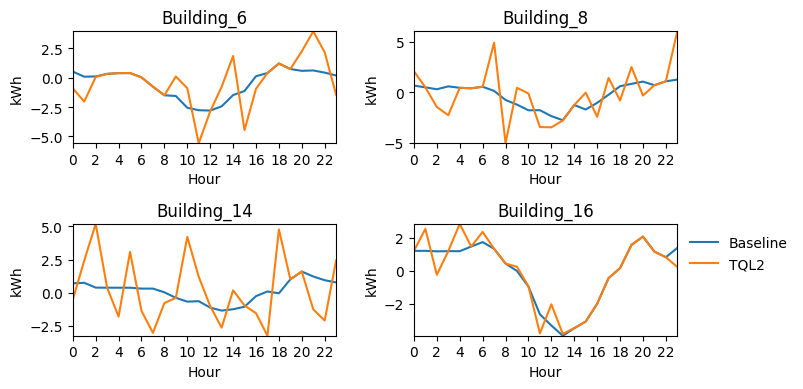

Battery SoC profiles:


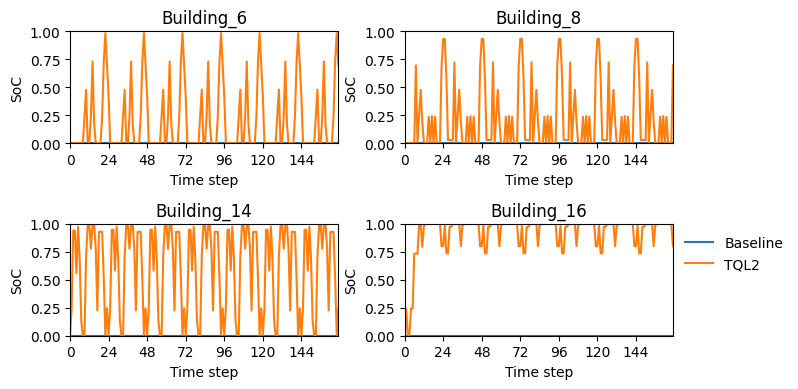

######## DISTRICT-LEVEL ########
District-level KPIs:


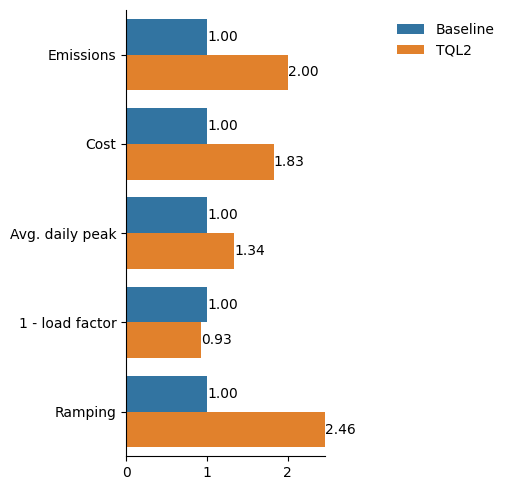

District-level simulation period load profiles:


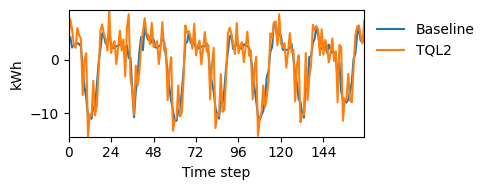

District-level daily-average load profiles:


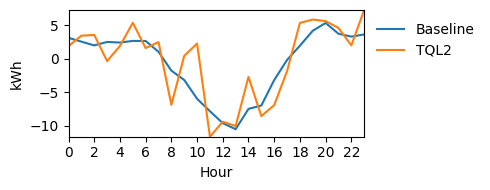

In [40]:
observations, _ = tql_env2.reset()

while not tql_env2.unwrapped.terminated:
    actions = tql_model2.predict(observations, deterministic=True)
    observations, _, _, _, _ = tql_env2.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    # 'TQL1': tql_env,
    'TQL2': tql_env2,
})

######## BUILDING-LEVEL ########
Building-level KPIs:


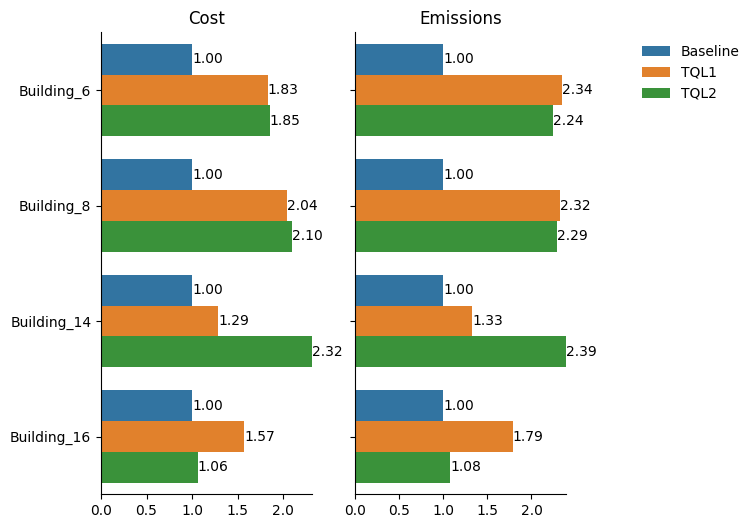

Building-level simulation period load profiles:


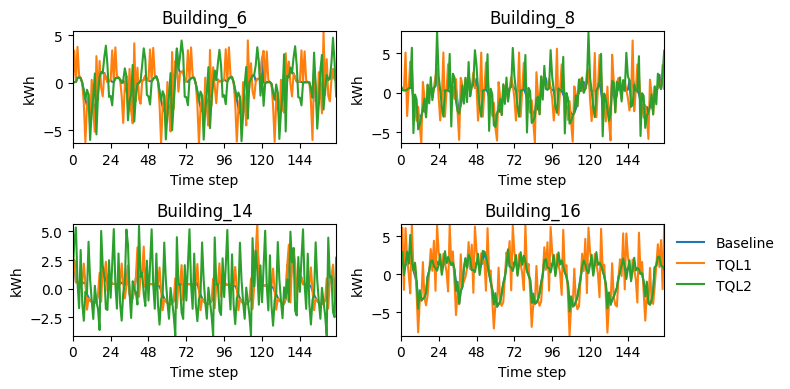

Building-level daily-average load profiles:


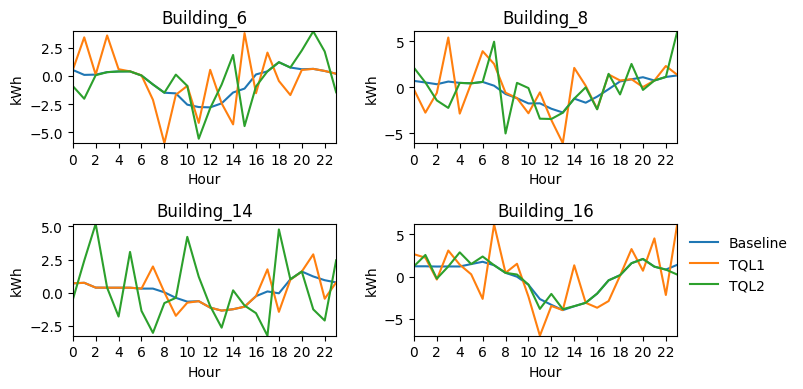

Battery SoC profiles:


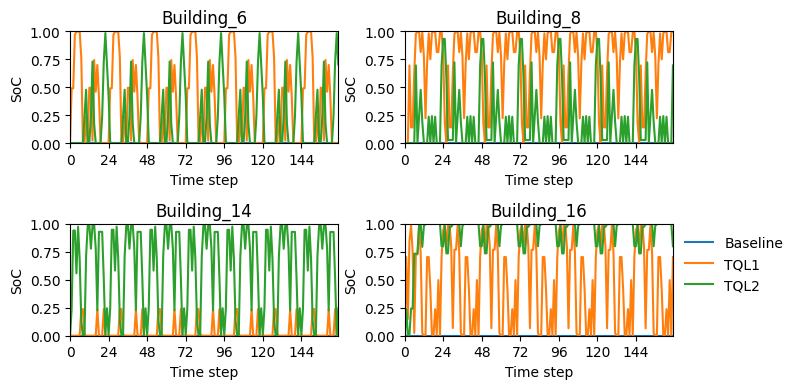

######## DISTRICT-LEVEL ########
District-level KPIs:


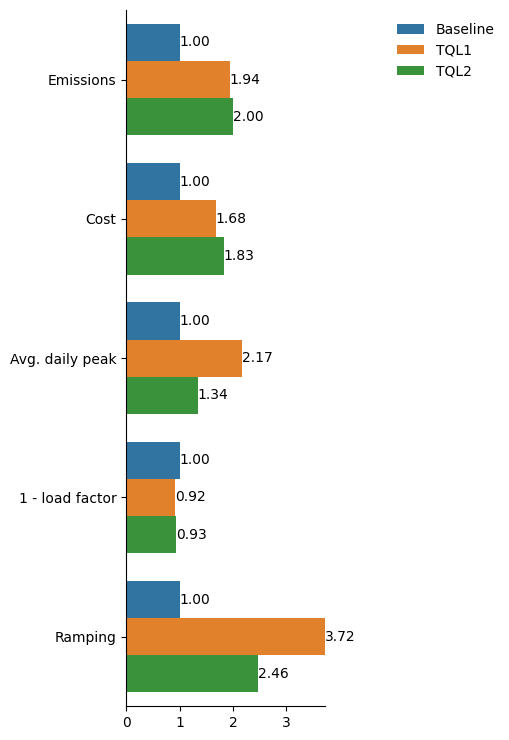

District-level simulation period load profiles:


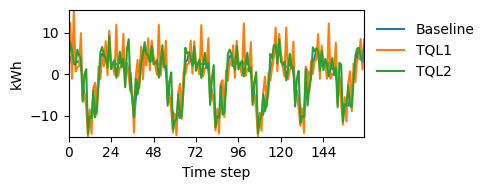

District-level daily-average load profiles:


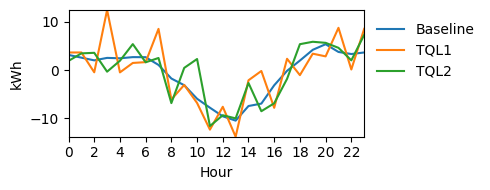

In [41]:
# plot summary and compare with other control results
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    'TQL1': tql_env,
    'TQL2': tql_env2,
})

<a name="experiment-3"></a>
# Experiment 3: Soft Actor-Critic (SAC)

---

In [42]:
sac_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [43]:
sac_env = NormalizedObservationWrapper(sac_env)

In [44]:
sac_env = StableBaselines3Wrapper(sac_env)

In [45]:
sac_model = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

In [48]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
fraction = 0.25
sac_episodes = int(tql_episodes*fraction)
print('Fraction of Tabular Q-Learning episodes used:', fraction)
print('Number of episodes to train:', sac_episodes)
sac_episode_timesteps = sac_env.unwrapped.time_steps - 1
sac_total_timesteps = sac_episodes*sac_episode_timesteps

# ------------------------------- TRAIN MODEL -----------------------------
for i in tqdm(range(sac_episodes)):
    sac_model = sac_model.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
    )

Fraction of Tabular Q-Learning episodes used: 0.25
Number of episodes to train: 258


100%|██████████| 258/258 [27:33<00:00,  6.41s/it]


######## BUILDING-LEVEL ########
Building-level KPIs:


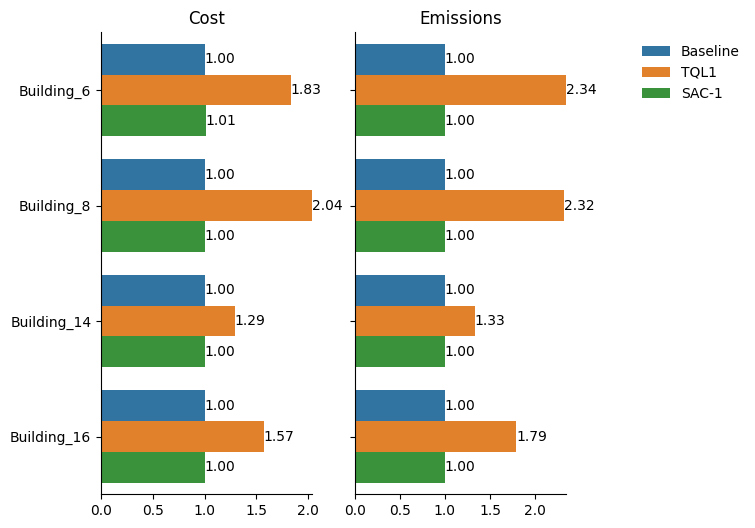

Building-level simulation period load profiles:


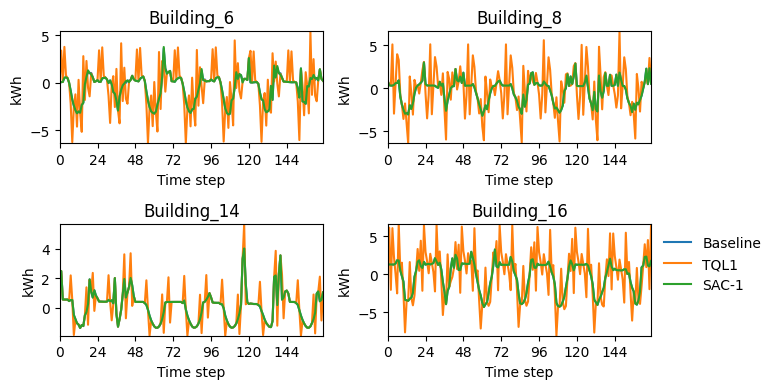

Building-level daily-average load profiles:


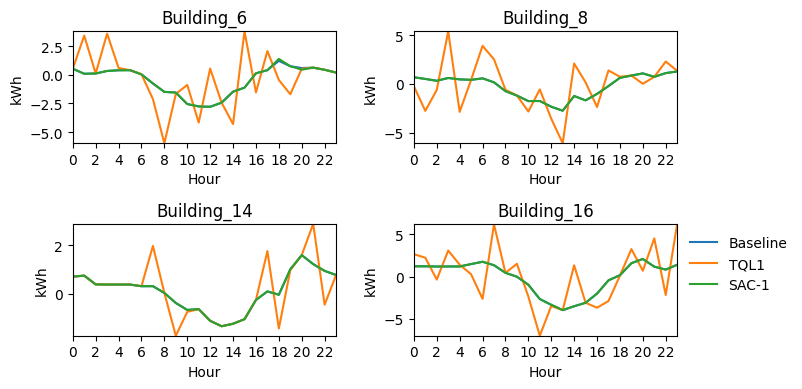

Battery SoC profiles:


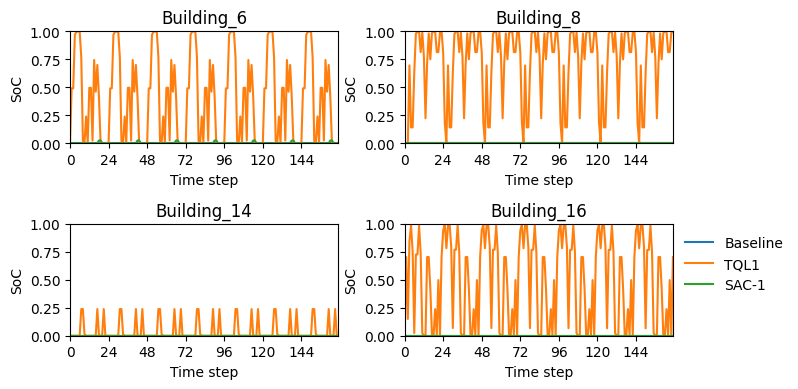

######## DISTRICT-LEVEL ########
District-level KPIs:


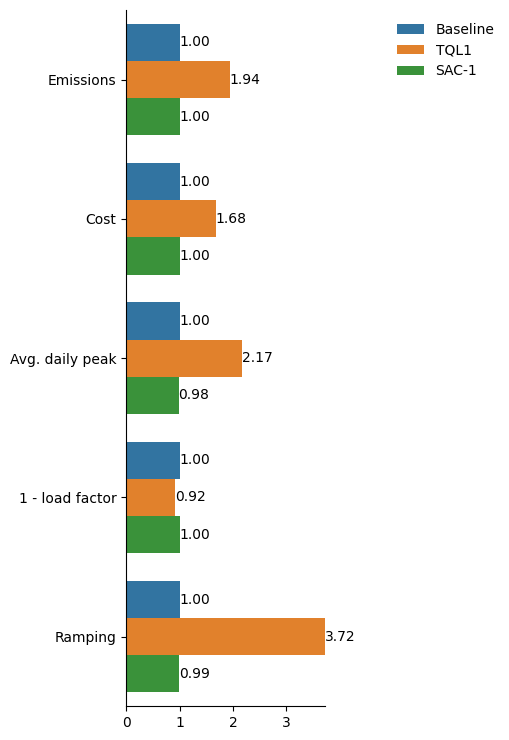

District-level simulation period load profiles:


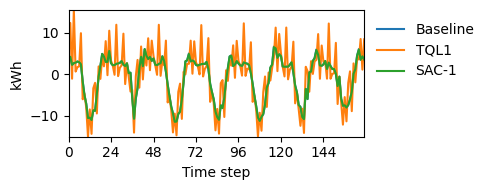

District-level daily-average load profiles:


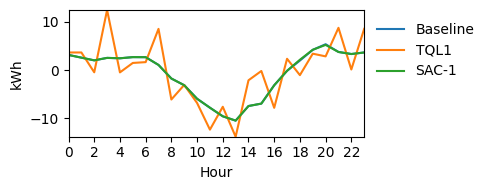

In [49]:
observations, _ = sac_env.reset()
sac_actions_list = []

while not sac_env.unwrapped.terminated:
    actions, _ = sac_model.predict(observations, deterministic=True)
    observations, _, _, _, _ = sac_env.step(actions)
    sac_actions_list.append(actions)

# plot summary and compare with other control results
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    'TQL1': tql_env,
    'SAC-1': sac_env,
    # 'MARLISA': marlisa_env,
})

In [46]:
class CustomReward(RewardFunction):
    def __init__(self, env_metadata: dict[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: dict[str, Any]:
            General static information about the environment.
        """

        super().__init__(env_metadata)

    def calculate(
        self, observations: list[dict[str, int | float]]
    ) -> list[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

In [50]:
sacr_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
    reward_function=CustomReward, # assign custom reward function
)
sacr_env = NormalizedObservationWrapper(sacr_env)
sacr_env = StableBaselines3Wrapper(sacr_env)
sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)

for i in tqdm(range(sac_episodes)):
    sacr_model = sacr_model.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
    )

100%|██████████| 258/258 [27:12<00:00,  6.33s/it]


######## BUILDING-LEVEL ########
Building-level KPIs:


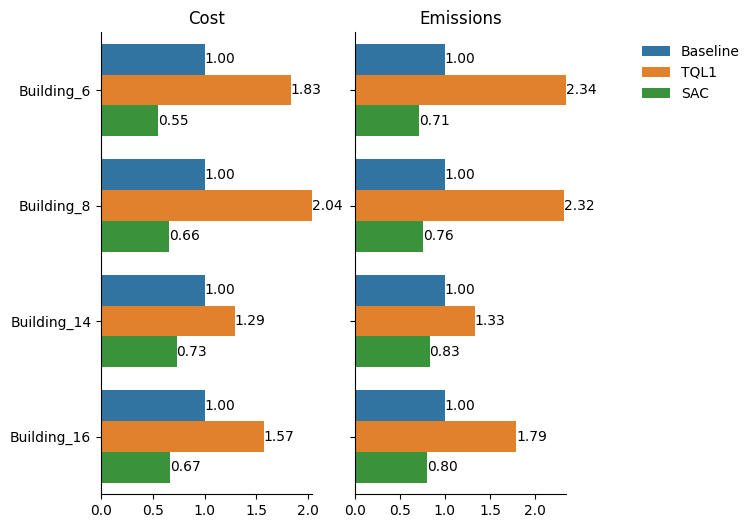

Building-level simulation period load profiles:


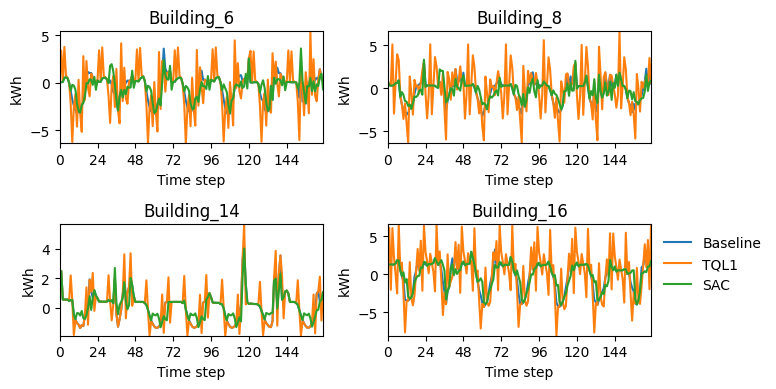

Building-level daily-average load profiles:


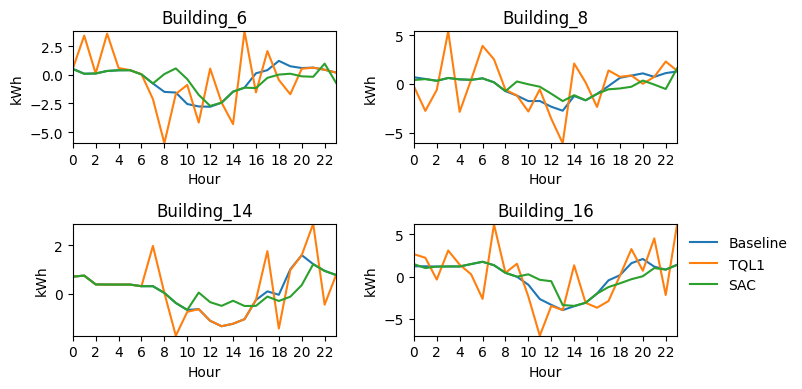

Battery SoC profiles:


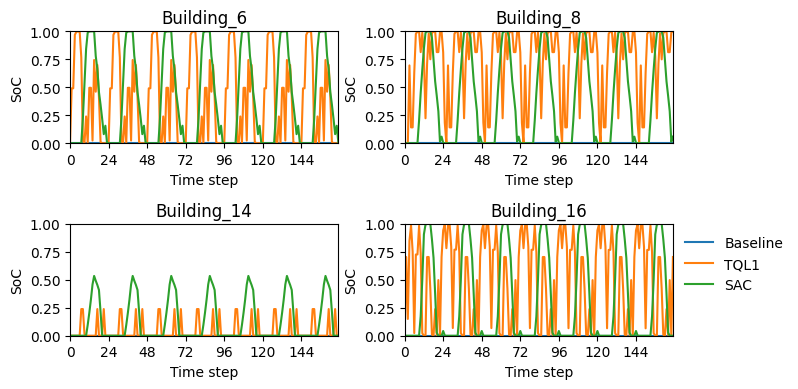

######## DISTRICT-LEVEL ########
District-level KPIs:


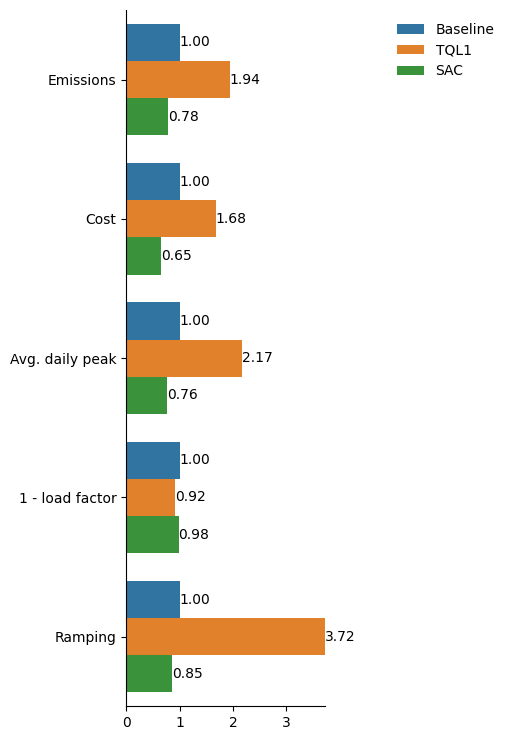

District-level simulation period load profiles:


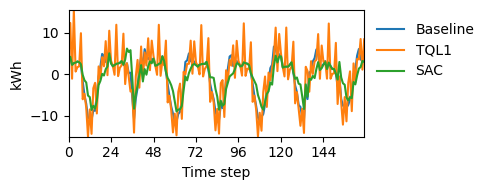

District-level daily-average load profiles:


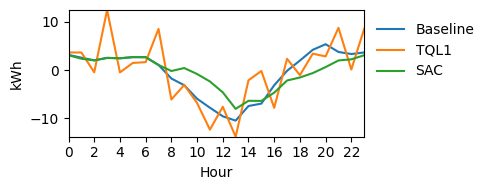

In [52]:
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    'TQL1': tql_env,
    # 'SAC-1': sac_env,
    'SAC': sacr_env,
    # 'MARLISA': marlisa_env,
})

<a name="experiment-4"></a>
# Experiment 4: Multi-Agent Reinforcement Learning with Iterative Sequential Action Selection (MARLISA)

---

In [57]:
sac_episodes

258

In [54]:
from citylearn.agents.marlisa import MARLISA as Agent
from citylearn.citylearn import CityLearnEnv
import pandas as pd
import time

# Initialize the environment with custom observations if needed
custom_active_observations = [
    'hour' ,     'net_electricity_consumption',
]
marlisa_env = CityLearnEnv(
    DATASET_NAME,  # Replace with actual dataset path
    central_agent=False,
    buildings=BUILDINGS,  # Replace with your specific building list or keep as None to use default
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP
)

marlisa_env = NormalizedObservationWrapper(marlisa_env)

model = Agent(
    env=marlisa_env,
    reward_function=CustomReward,
    seed=RANDOM_SEED
)

try:
    print("Standardize start time step:", model.standardize_start_time_step)
except AttributeError as e:
    print("Error accessing standardize_start_time_step:", e)

# Train the MARLISA agent
print("Training MARLISA agent...")
start_time = time.time()
try:
    model.learn(episodes=sac_episodes, deterministic_finish=True)  # Adjust episodes as needed
    print("Training complete!")
except Exception as e:
    print("Error during training:", e)
print("--- %s seconds ---" % (time.time() - start_time))


Standardize start time step: 167
Training MARLISA agent...
Training complete!
--- 10617.423429489136 seconds ---


######## BUILDING-LEVEL ########
Building-level KPIs:


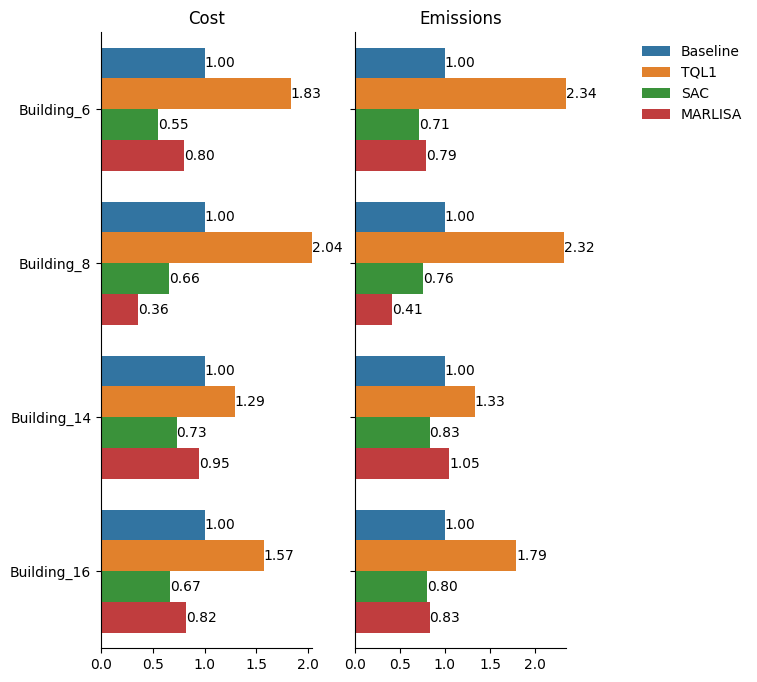

Building-level simulation period load profiles:


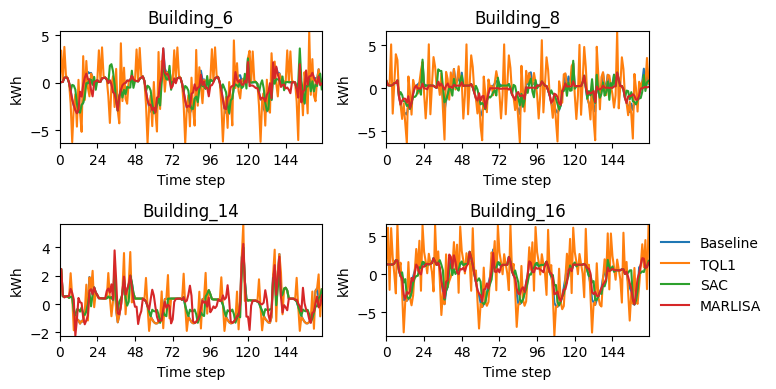

Building-level daily-average load profiles:


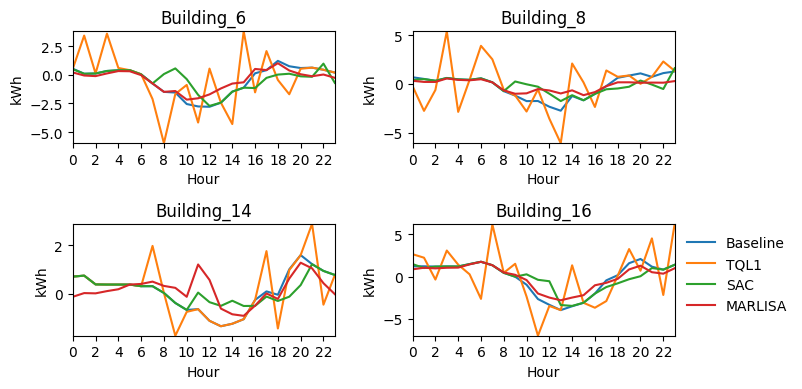

Battery SoC profiles:


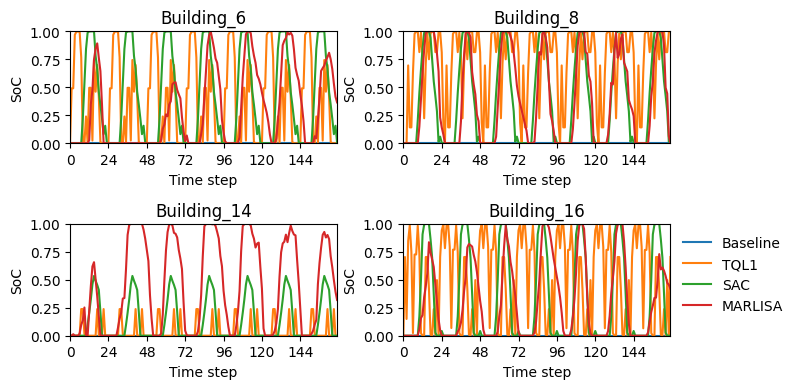

######## DISTRICT-LEVEL ########
District-level KPIs:


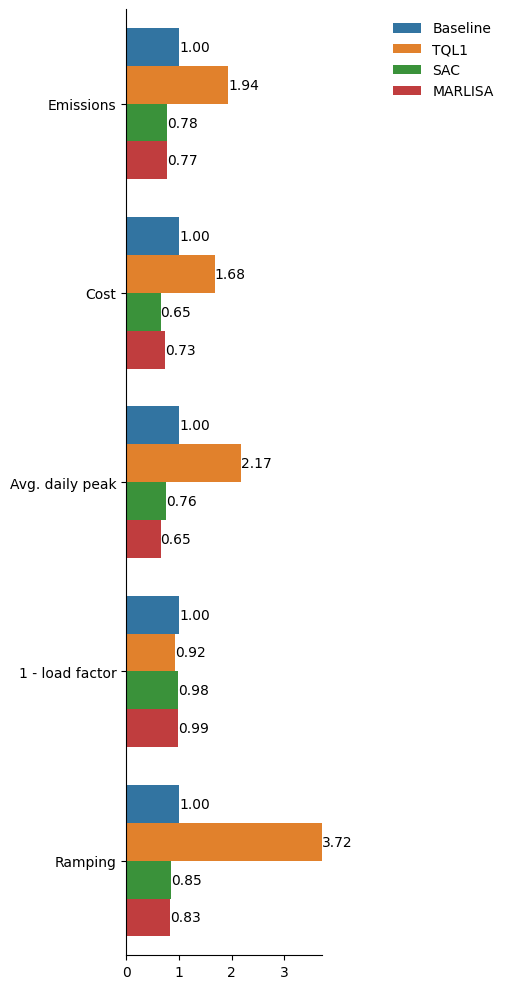

District-level simulation period load profiles:


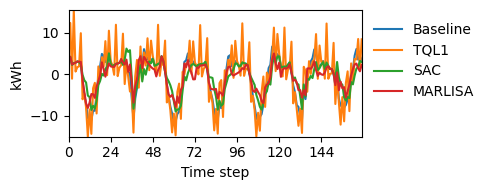

District-level daily-average load profiles:


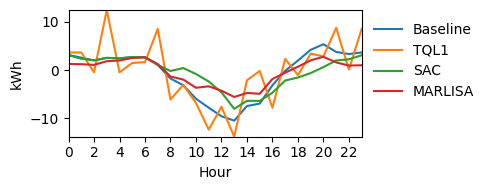

In [58]:
try:
    observations, _ = marlisa_env.reset()
    marlisa_actions_list = []

    while not marlisa_env.unwrapped.terminated:
        actions = model.predict(observations, deterministic=True)
        observations, _, _, _, _ = marlisa_env.step(actions)
        marlisa_actions_list.append(actions)
except Exception as e:
    print("Error during evaluation:", e)

plot_simulation_summary({
    'Baseline': baseline_env,
    'TQL1': tql_env,
    'SAC': sacr_env,
    'MARLISA': marlisa_env,
})

## FINAL PLOTS

---

######## BUILDING-LEVEL ########
Building-level KPIs:


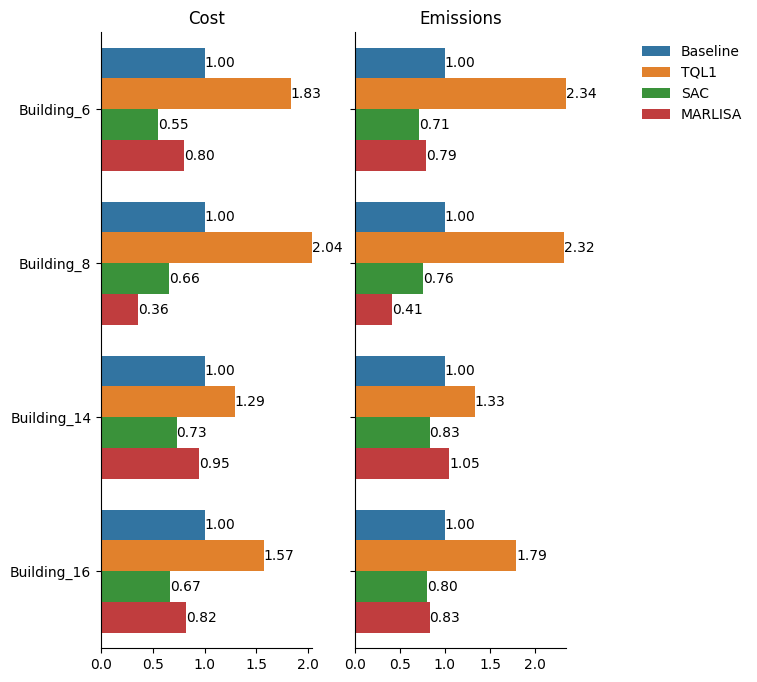

Building-level simulation period load profiles:


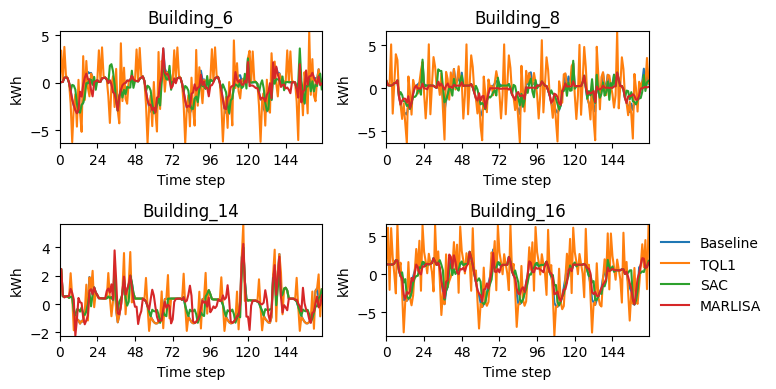

Building-level daily-average load profiles:


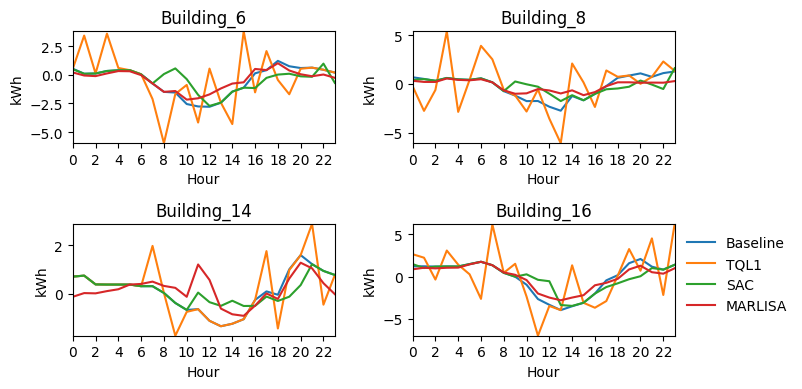

Battery SoC profiles:


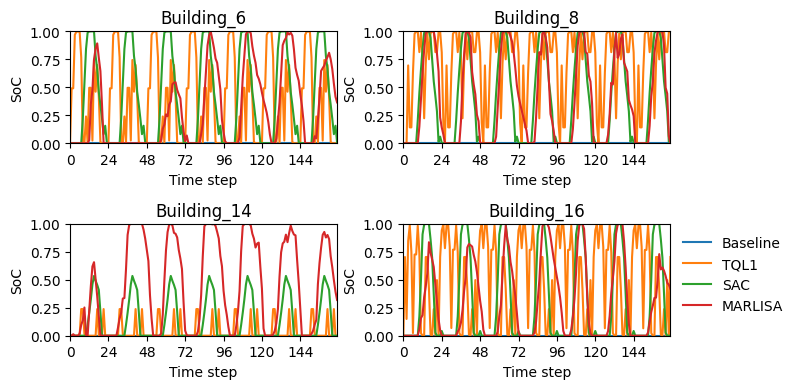

######## DISTRICT-LEVEL ########
District-level KPIs:


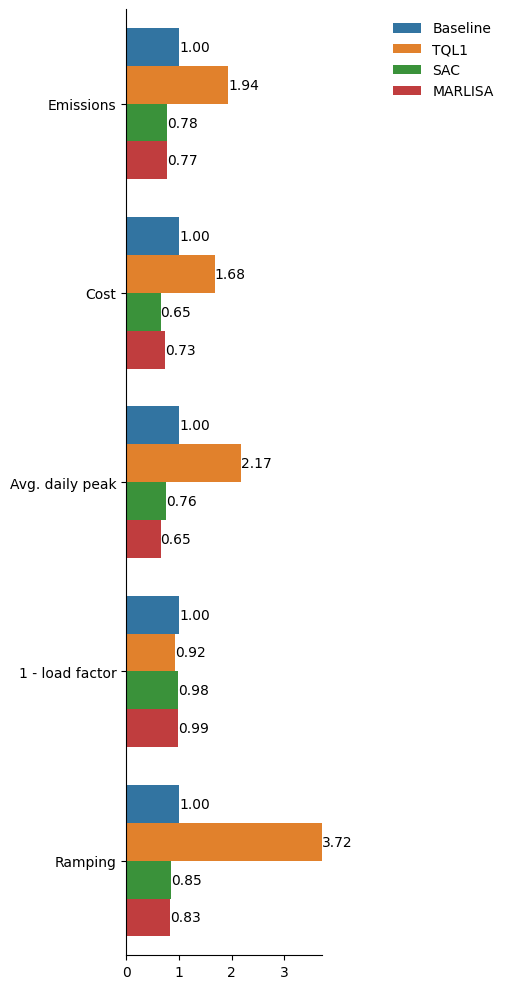

District-level simulation period load profiles:


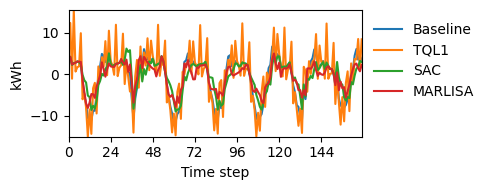

District-level daily-average load profiles:


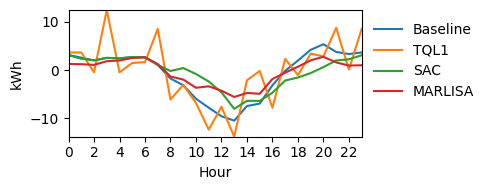

In [59]:
plot_simulation_summary({
    'Baseline': baseline_env,
    'TQL1': tql_env,
    # 'TQL2': tql_env2,
    # 'SAC-1': sac_env,
    'SAC': sacr_env,
    'MARLISA': marlisa_env,
})

######## BUILDING-LEVEL ########
Building-level KPIs:


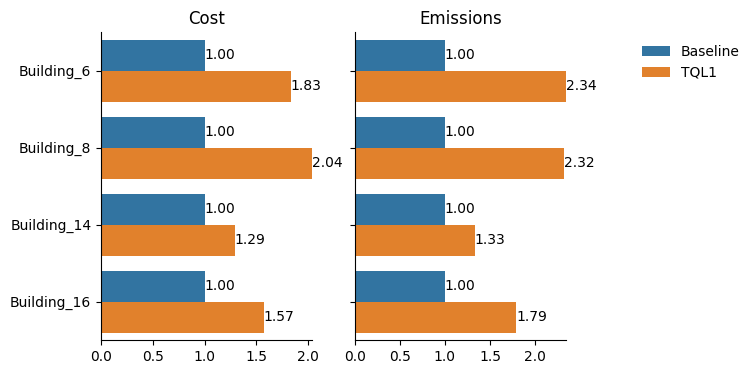

Building-level simulation period load profiles:


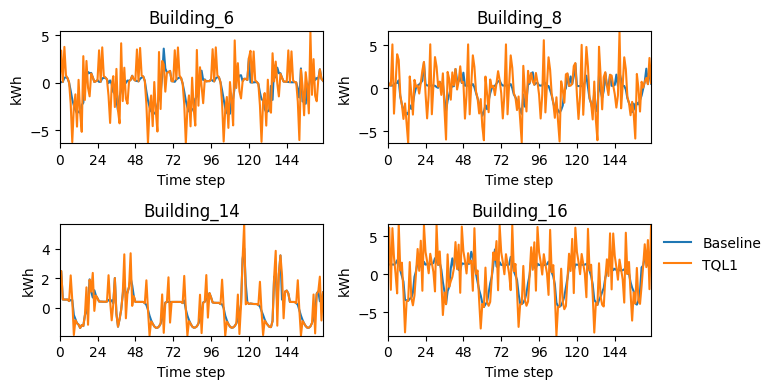

Building-level daily-average load profiles:


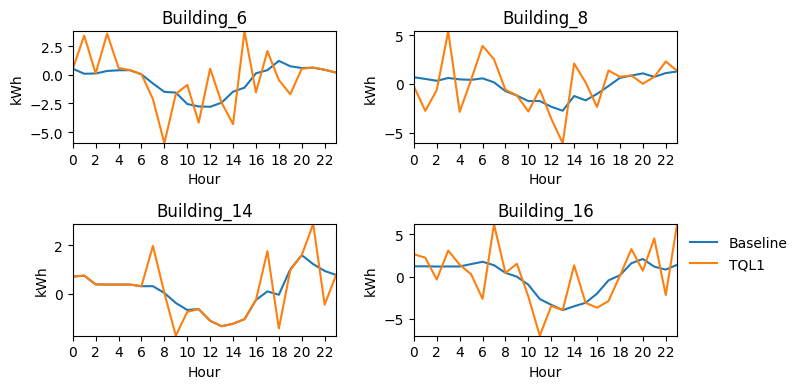

Battery SoC profiles:


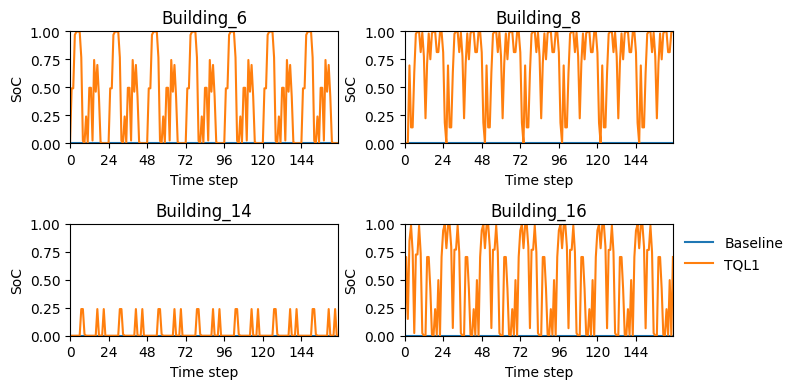

######## DISTRICT-LEVEL ########
District-level KPIs:


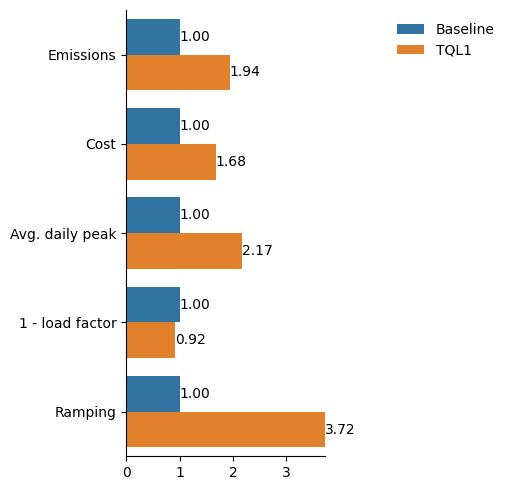

District-level simulation period load profiles:


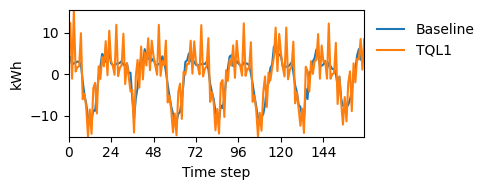

District-level daily-average load profiles:


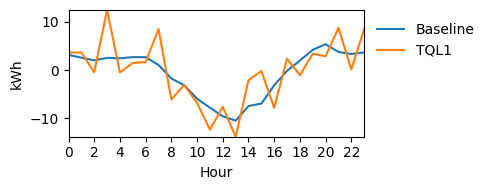

In [60]:
plot_simulation_summary({
    'Baseline': baseline_env,
    'TQL1': tql_env,
    # 'TQL2': tql_env2,
    # 'SAC-1': sac_env,
    # 'SAC': sacr_env,
    # 'MARLISA': marlisa_env,
})

######## BUILDING-LEVEL ########
Building-level KPIs:


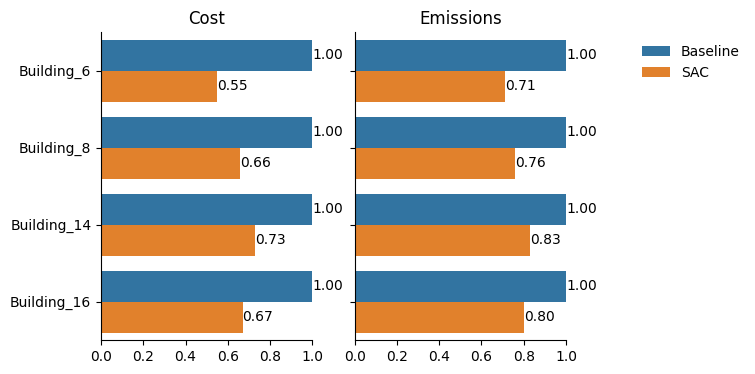

Building-level simulation period load profiles:


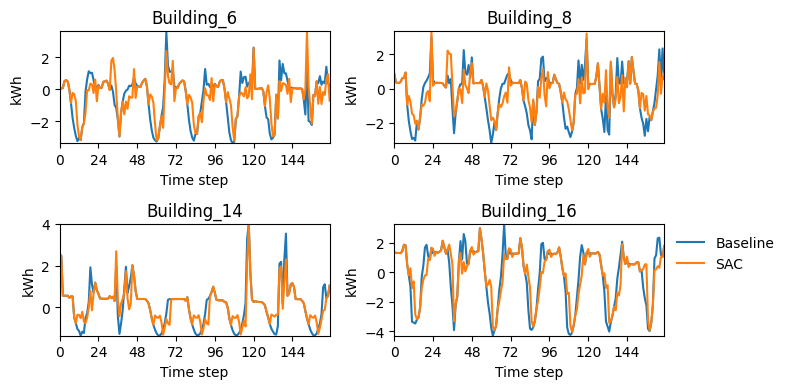

Building-level daily-average load profiles:


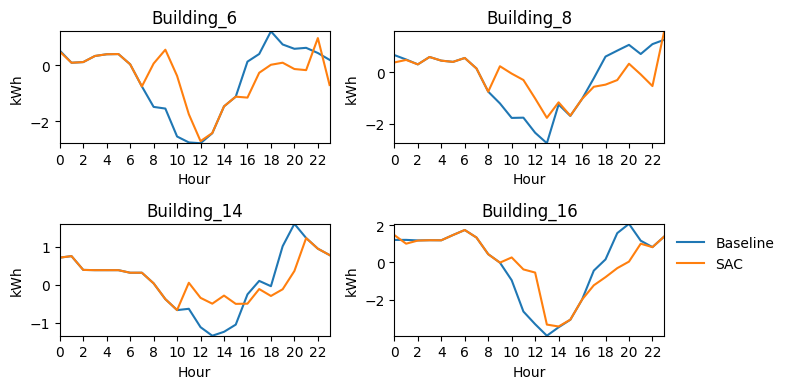

Battery SoC profiles:


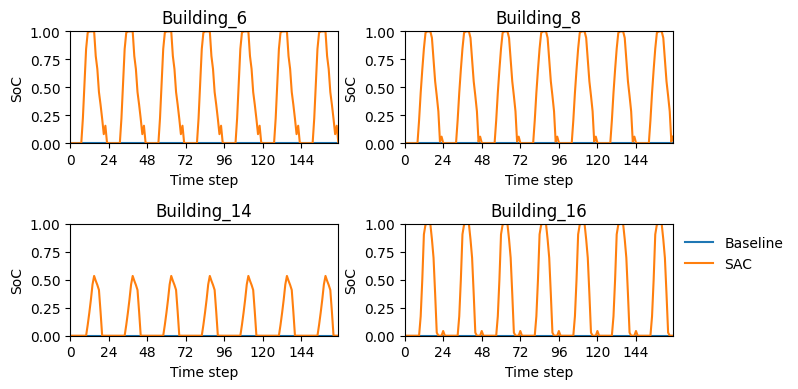

######## DISTRICT-LEVEL ########
District-level KPIs:


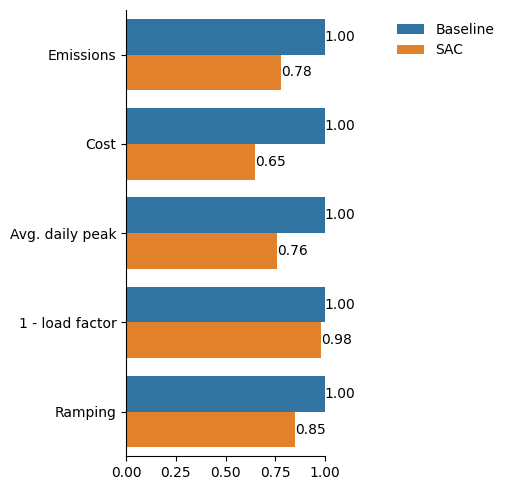

District-level simulation period load profiles:


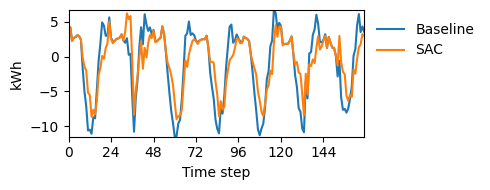

District-level daily-average load profiles:


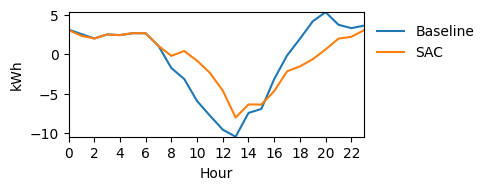

In [61]:
plot_simulation_summary({
    'Baseline': baseline_env,
    # 'TQL1': tql_env,
    # 'TQL2': tql_env2,
    # 'SAC-1': sac_env,
    'SAC': sacr_env,
    # 'MARLISA': marlisa_env,
})

######## BUILDING-LEVEL ########
Building-level KPIs:


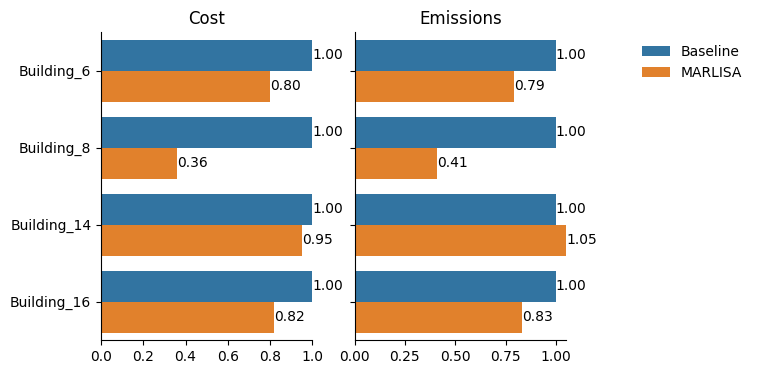

Building-level simulation period load profiles:


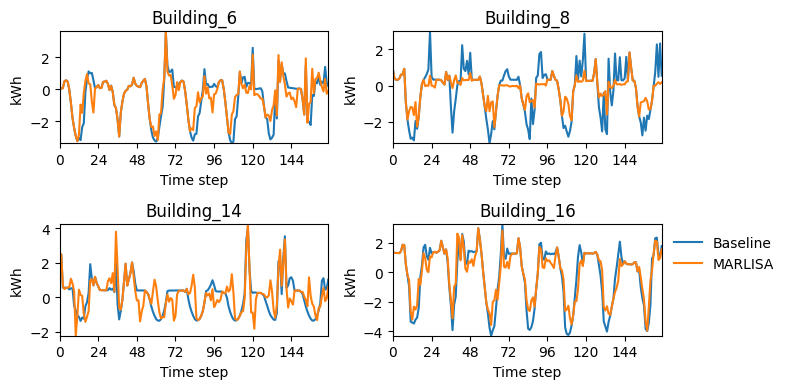

Building-level daily-average load profiles:


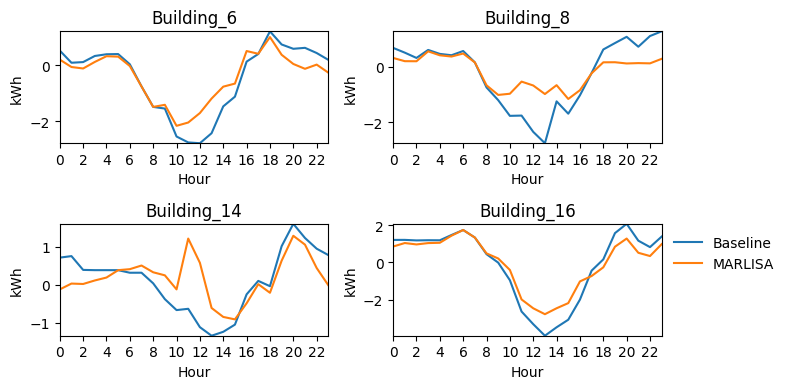

Battery SoC profiles:


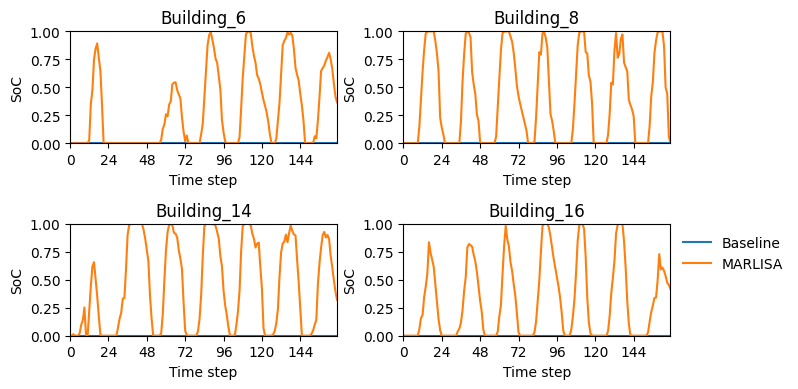

######## DISTRICT-LEVEL ########
District-level KPIs:


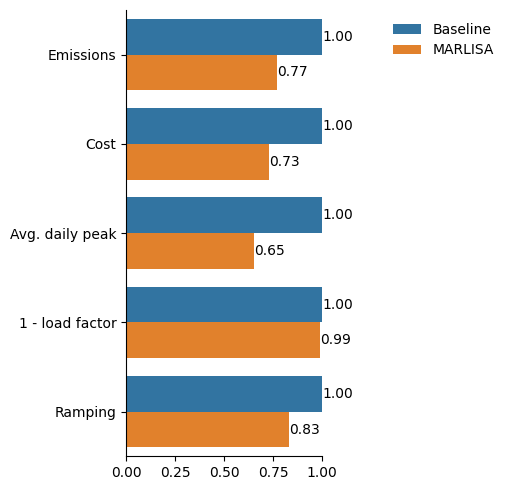

District-level simulation period load profiles:


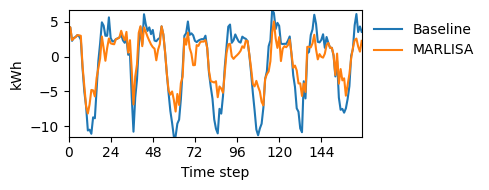

District-level daily-average load profiles:


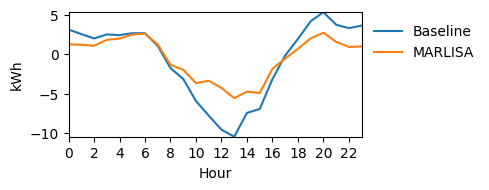

In [62]:
plot_simulation_summary({
    'Baseline': baseline_env,
    # 'TQL1': tql_env,
    # 'TQL2': tql_env2,
    # 'SAC-1': sac_env,
    # 'SAC': sacr_env,
    'MARLISA': marlisa_env,
})